In [20]:
import matplotlib.pyplot as plt
import glob
import sys
sys.path.append('../radar_mesure')
from radar import RadarMesure
from scipy.signal import find_peaks
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

from scipy.optimize import curve_fit

c = 299792458
lambdaa = c/(17e9)
sigmacr = 0.073       ## sigmaboule
pad_factor = 4 



def bin_to_dist(x,pad_factor=1):
    c = 299792458
    B = 2e9   #bandwith
    ramptime = 102400e-9
    frequence_echantillonage = 10e6 
    rangebinresolution = frequence_echantillonage/1024              #DF
    fb = x*rangebinresolution
    dist = fb*c*ramptime/(2*B)
    dist=dist/pad_factor
    return(dist)

    
# Chemin vers le fichier
data = glob.glob('/home/nicolas/Documents/Dku-toolbox/data/calisphere/17*.txt')
data.sort()
# Création de l'instance
ri = []
[ri.append(RadarMesure(i,beta = 8, pad_factor = pad_factor, calib= True)) for i in data]

[None, None, None, None, None, None, None, None, None, None, None]

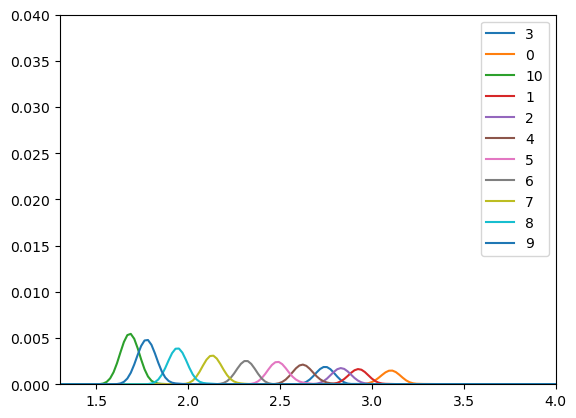

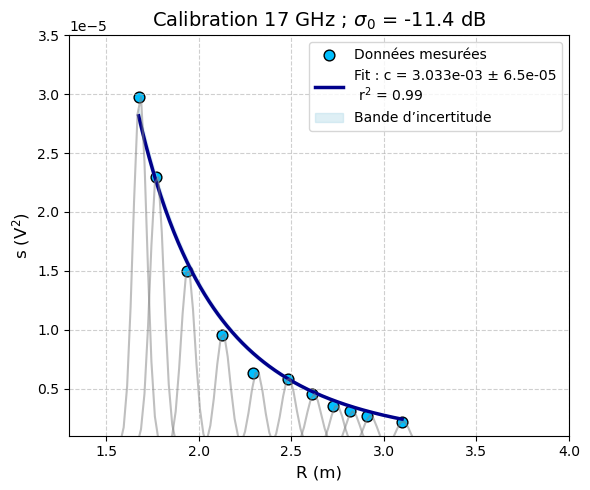

In [24]:
def func(R, c):
    return (c * (sigmacr) / (R**4))
pic = []

for i in ri :
    df = i.df
    peaks,prop = find_peaks(df.copol.loc[1:5],height=0.001)
    if len(peaks) != 0 :
        pic.append((bin_to_dist(peaks[0],pad_factor)+1,prop['peak_heights'][0]**2))
    plt.plot(df.index,df.copol,label = i.numero)
plt.xlim(1.3 ,4)
plt.ylim(0,0.04)

#plt.xlim(0,4)
plt.legend()
plt.show()

dfpic = pd.DataFrame(pic).sort_values(by=[0]) 
df_corrigé=dfpic

X= np.asarray(df_corrigé[0])
y = np.asarray(df_corrigé[1])


lower_bounds = [-1]
upper_bounds = [1]
bounds = (lower_bounds, upper_bounds)

popt, pcov = curve_fit(func, X, y, bounds=bounds)

y_pred = func(X, *popt)
r2 = r2_score(y, y_pred)

# Préparation du fit
x_fit = np.linspace(X.min(), X.max(), 300)
y_fit = (func(x_fit, *popt))

# Erreur sur le paramètre c
perr = np.sqrt(np.diag(pcov))
c_err = perr[0]

# Calcul de r2 
r2 = r2_score(y,func(X, *popt))

# Calcul bande d'incertitude
y_fit_upper = (func(x_fit, *(popt[0] + c_err,)))
y_fit_lower = (func(x_fit, *(popt[0] - c_err,)))





# Visualisation du fit calibration avec |S(t)| en y et distance R en x
fig, ax = plt.subplots(figsize=(6, 5))


# Scatter des points mesurés
ax.scatter(X, y, s=60, facecolors='deepskyblue', edgecolors='black', label='Données mesurées')


# Tracer la courbe de fit
ax.plot(x_fit, y_fit, color='darkblue', linewidth=2.5, label=f'Fit : c = {popt[0]:.3e} ± {c_err:.1e}\n r$^2$ = {r2 :.2f}')

# Tracer la bande d’incertitude
ax.fill_between(x_fit, y_fit_lower, y_fit_upper, color='lightblue', alpha=0.4, label='Bande d’incertitude')

# Ajouter l'équation en LaTeX sur la figure
eq_text = r"$|S(t)|^2 = \dfrac{c \, \sigma^0_{cr}}{R^4}$"
#ax.text(0.65, 0.70, eq_text, transform=ax.transAxes, fontsize=14,
#        verticalalignment='top', bbox=dict(boxstyle="round", facecolor="white", alpha=0.6))



for i in ri :
    df = i.df
    ax.plot(df.index,df['copol']**2,color = 'grey', alpha = 0.5)

# Titres et labels
ax.set_xlabel("R (m)", fontsize=12)
ax.set_ylabel(r"s (V$^2$)", fontsize=12)
ax.set_title(rf"Calibration 17 GHz ; $σ_0$ = {10*np.log10(sigmacr) : .1f} dB", fontsize=14)
ax.set_xlim(1.3 ,4)
ax.set_ylim(1e-6,3.5e-5)
#ax.set_yscale('log')
#ax.set_xscale('log')

# Grille et légende
ax.grid(True, which='both', linestyle='--', alpha=0.6)
ax.legend(fontsize=10)

# Layout propre
plt.tight_layout()
plt.savefig('../fig/17loglogzoomé.png')
plt.show()

In [16]:
sigmacr

0.073